# **Age, Gender and Ethnicity Prediction from Face Images**

### **preview**

#### **Introduction**

The human face conveys much information, which people have a remarkable ability to extract, identify, and interpret. Age and gender are known to influence the structure and appearance of the face, and human observers can reliably infer both. Recently, there has been an increase in the development of automatic facial analysis techniques with a view for developing machine-based systems that mimic these abilities of the human visual system. Both being demographic attributes of the human face, they play important roles in real-life applications that include biometrics, demographic studies, targeted advertisements, human–computer interaction systems, and access control. With much progress in automatic face detection and recognition, much research is now focused on automatic demographic identification.

Humans are able to determine an individual's age, gender, and ethnicity relatively easily using facial features, but machines are still challenged to perform this task, even though over the past decade amazing strides have been taken in automatically predicting facial demographics.

In this project we will try to offer several ways to approach this highly important task of classification and estimation, and we will try to use the best one using several key parameters. we hope that in the end of this article our best method may even do a better job in this task than us, humans.

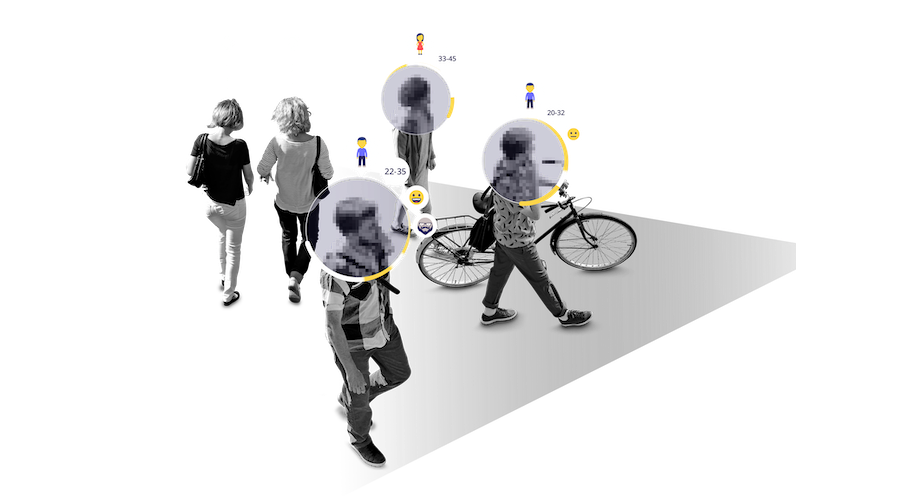

in the picture above: using face recognition to estimate age, gender, and maybe even mood of passers in real-time

#### **The problem**

Research on facial aging can be categorized into age estimation, age progression, and age invariant face recognition (AIFR). Age estimation refers to the automatic labeling of age groups or the specific ages of individuals using information obtained from their faces. Age progression reconstructs the facial appearance with natural aging effects, and AIFR focuses on the ability to identify or verify people’s faces automatically, despite the effects of aging. In this work, we are focused on age estimation.

Gender classification automatically assigns one of the two sex labels (male/female) to a facial image. Studies have shown that we humans are able to differentiate between adult male and female faces with up to 95% accuracy. 

Since the features of visual data, and especially in our case, is simply 2D list of pixels, we are bound to them and we don't really have meaningful features to learn from.

Therefor an initial and key step in age and gender classification is feature extraction; this is the process of parameterizing the face with a view for defining an efficient descriptor. Arming with the tools that we gained from the course, we'll try to see how every approach handles with the task of classification face images.
Later on we'll try to extract features from the pixels we have, using the tools from our course.


### **Data Overview**

#### **Setup**

In [ ]:
import pandas as pd
import sys
import sklearn as skl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px
import keras
from tensorflow.keras import layers as L


In [ ]:
# connect to google drive to handle files directly from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Background**

Our main source of data comes from UTKFace dataset. This is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.  
 

Here are some of the picture in UTKFace dataset

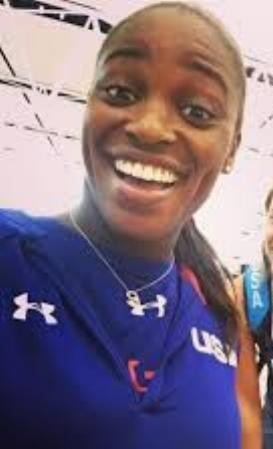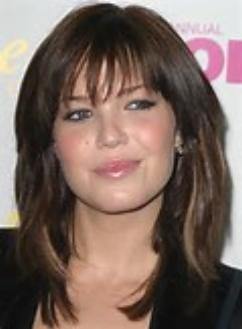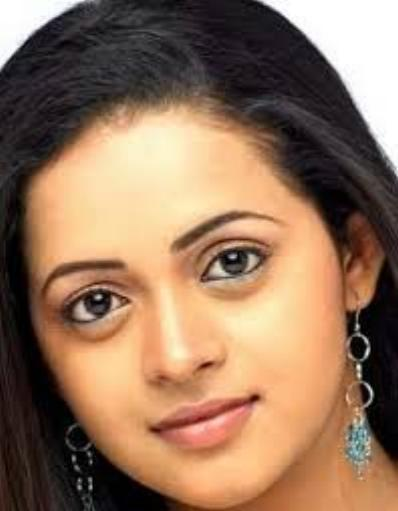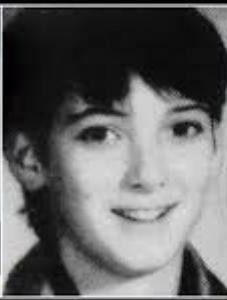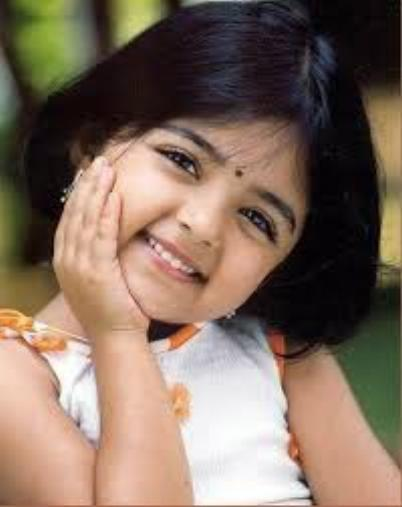

However, to save a lot of our truble and to focus only on the classification task, we will first try to use a **similar** dataset from **kaggle**. This dataset is basically the same pictures from UTKFace dataset, only that in this set the pictures are only pictures of the faces themself, and the dimention (or resolution) of the pictures is much lower, so in a way we can concentrate only on the details and the features that we need to perform the classification.

**Schema**

The main feature in our csv files is of course the "Pixles" column, which contains the pixels of the picture. In the original file every value in this column contains a string of 2304 values, which we'll have to convert to a matrix of 48x48 integers in order to use our algorithms on the data.

The next important features are the classification features - age, gender, and ethnicity. We'll try to examine the distribution in each one of these features, and we'll try to understand what the data is telling us in order to reach better understanding on how to solve this problem in the best way possible.

In [ ]:
# load the file from my drive 
path = "/content/drive/My Drive/age_gender.csv"   # path to the file in my google-drive
dataset = pd.read_csv(path)
print(dataset.shape)
dataset.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


To summarize, the **labels** of the data in details are:
*  [age] is an integer from 0 to 116, indicating the age
*  [gender] is either 0 (male) or 1 (female)
*  [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).


In [ ]:
dataset.shape

(23705, 5)

In [ ]:
dataset = dataset.drop("img_name", axis=1)    # currently we don't need this column

In [ ]:
dataset.isnull().sum()

age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [ ]:
old_size = dataset.shape[0]
dataset.drop_duplicates(subset='pixels', inplace=True)      # make sure we don't have duplicates
new_size = dataset.shape[0]
print(f"number of duplicates: {old_size - new_size}")



number of duplicates: 390


In [ ]:
columns = ["age","gender","ethnicity"]
y = dataset.drop("pixels", axis = 1)   # our labels
x = dataset.drop(columns, axis = 1)    # our features

In [ ]:
x.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [ ]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

In [ ]:
# transform the string represetation of pixels into arrays of integers
def transform_to_int(cell):
  array = np.array(list(map(int, cell.split(" "))))
  array = array.reshape(48, 48)
  return array


In [ ]:
dataset['pixels'] = dataset['pixels'].apply(lambda cell: transform_to_int(cell))


**Let's show some pictures using the Pixels column that we just transformed:**

In [ ]:
# translate the data according to its meaning 
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}   
gender_mapping = {0:"Male", 1:"Female"}

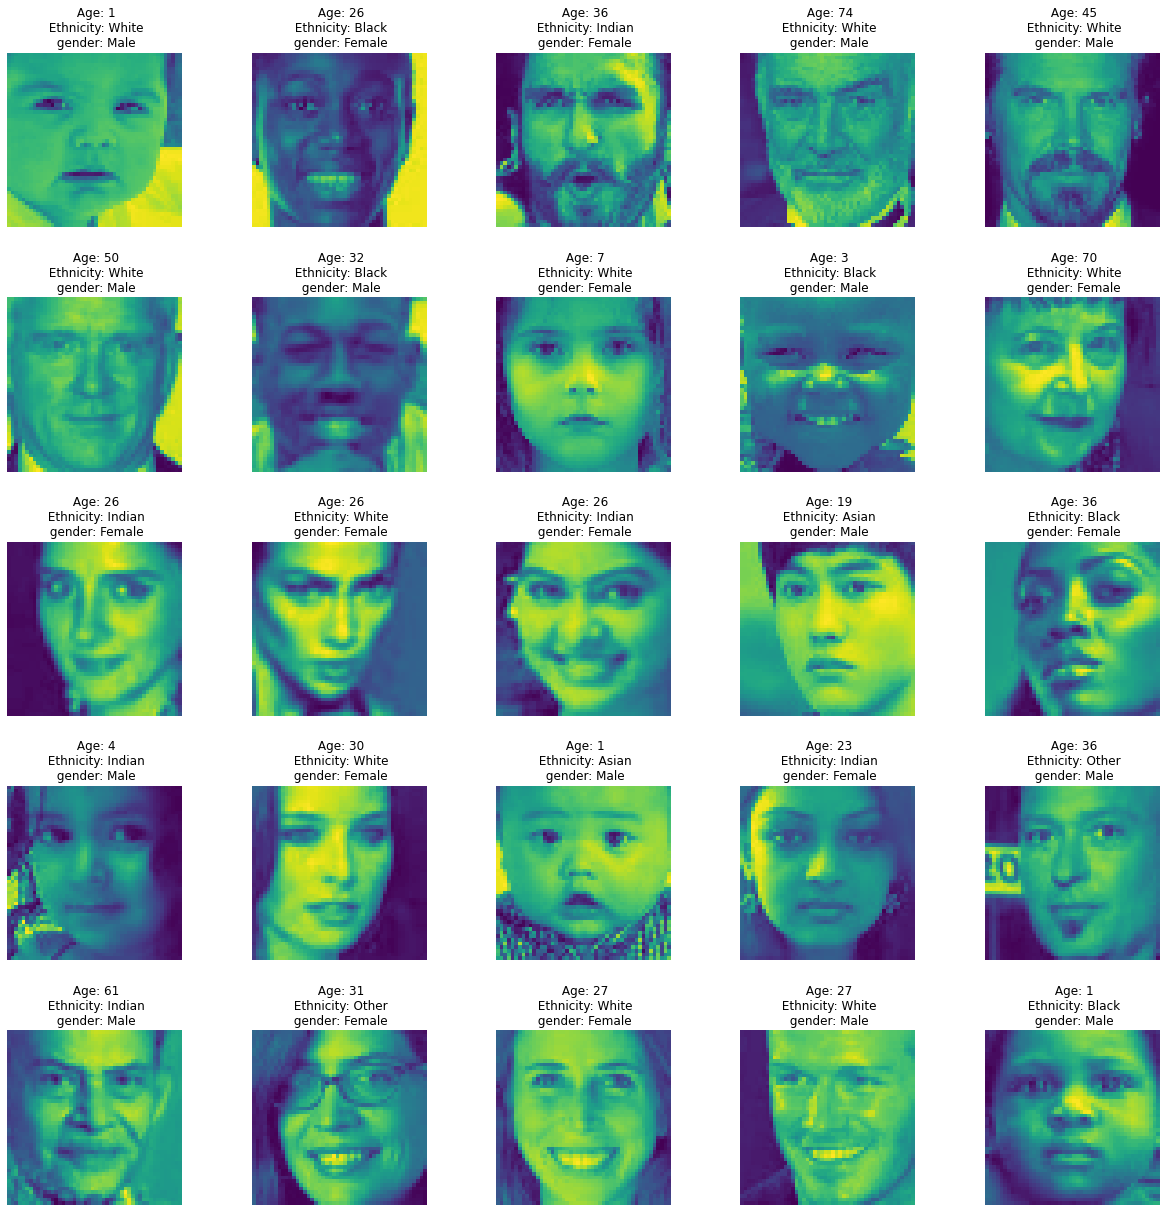

In [ ]:
def get_image(row):
    age = row['age']
    ethnicity = row['ethnicity']
    gender = row['gender']
    image = row['pixels']/255

    return image, age, ethnicity, gender

def show_pictures():
  plt.figure(figsize=(20, 20))

  for i in range(25):
    #select random image
    index = np.random.randint(0, len(dataset))
    image, age, ethnicity, gender = get_image(dataset.iloc[index])

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(age, ethnicity_mapping[ethnicity], gender_mapping[gender]))
    plt.axis('off')
  
  # adjust the subplot spaces to show all the details
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

  plt.show()

show_pictures()

### **EDA**

#### **Explore data distribution**

Here we'll try to understand more about the data by going a bit further into the data and see the distribution of every class in the data.  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Age Distribution')

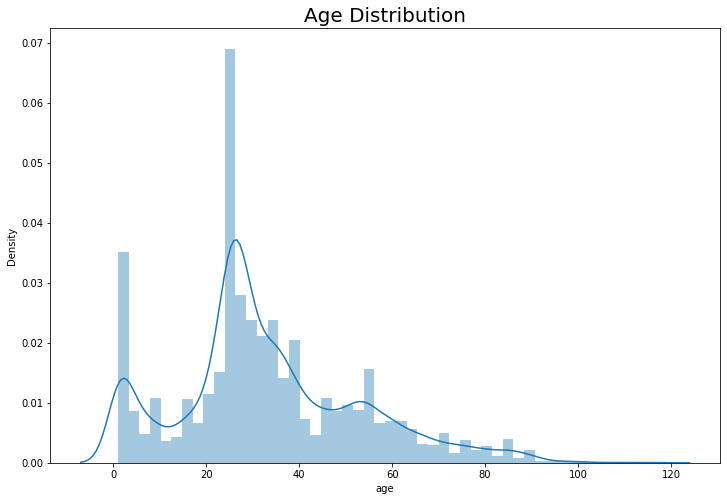

In [ ]:
fig = plt.figure(figsize=(12,8))
g = sns.distplot(dataset['age'])
g.set_title(label="Age Distribution", fontsize=20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



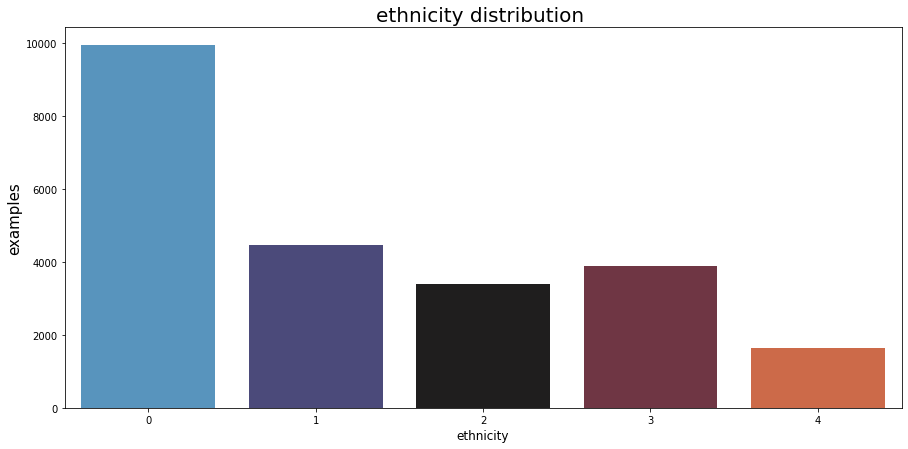

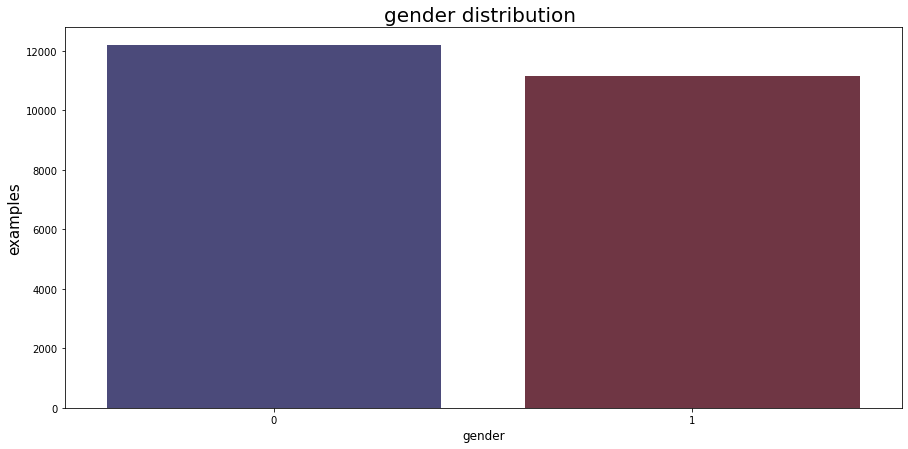

In [ ]:
for i in y.columns[1:] :
    plt.figure(figsize=(15,7))
    g = sns.countplot(y[i], palette="icefire")
    g.set_xlabel(i, fontsize=12)
    g.set_ylabel("examples", fontsize=15)
    plt.title(f"{i} distribution ", fontsize=20)
    

for more simplicity in the Age label we'll seperate it into bins:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of age')

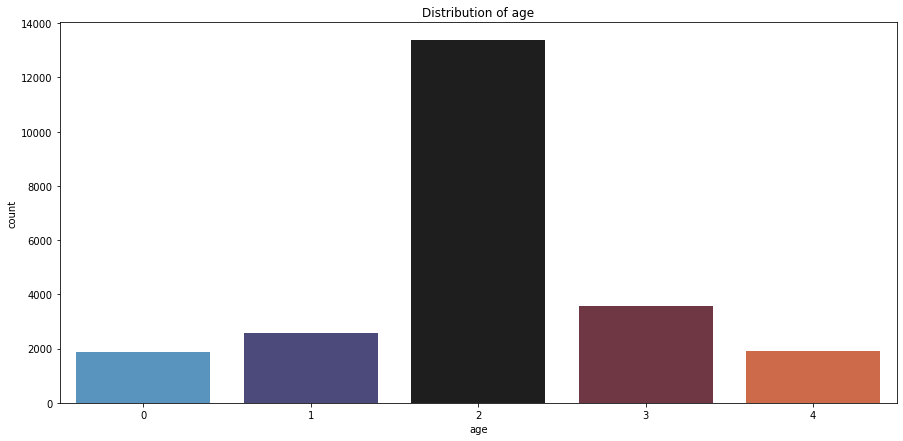

In [ ]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
plt.figure(figsize=(15,7))
g = sns.countplot(y["age"], palette="icefire")

plt.title("Distribution of age")

**Age**: We can see that we have a lot of data on babies (age = 1) and the majority of the data is located in the 20-40 group.   
We can see it much clearer in the violin plot in the next section.

**Gender**: here we have slightly more males than females. we'll see later the distribution in relation to age 


**Ethnicity**: It's easy to see that the data in the White group is way larger in relation to the other groups. Later we'll see all the data in relation to each one of the labels

In [ ]:
## calculating distributions
age_dist = dataset['age'].value_counts()
ethnicity_dist = dataset['ethnicity'].value_counts().rename(ethnicity_mapping)
gender_dist = dataset['gender'].value_counts().rename(index=gender_mapping)

def violin_plot(y, data,x="", x_name="", xticklabels=[], legend=False, hue=""):
    plt.figure(figsize=(10, 10), dpi=80)
    if x == "":
       ax = sns.violinplot(y = y, data=data, split = True, inner="quart")
    elif legend:
      ax = sns.violinplot(y = y,x=x, data=data, split = True, hue=hue, inner="quart")
      ax.legend(handles=ax.legend_.legendHandles, labels=[gender_mapping[i] for i in range(2)])
    else:
      ax = sns.violinplot(y = y,x=x, data=data, split = True, inner="quart")
    ax.set_ylabel('Age', fontsize=15)
    ax.set_xlabel(x_name, fontsize=15)
    ax.set_xticklabels(xticklabels)
      



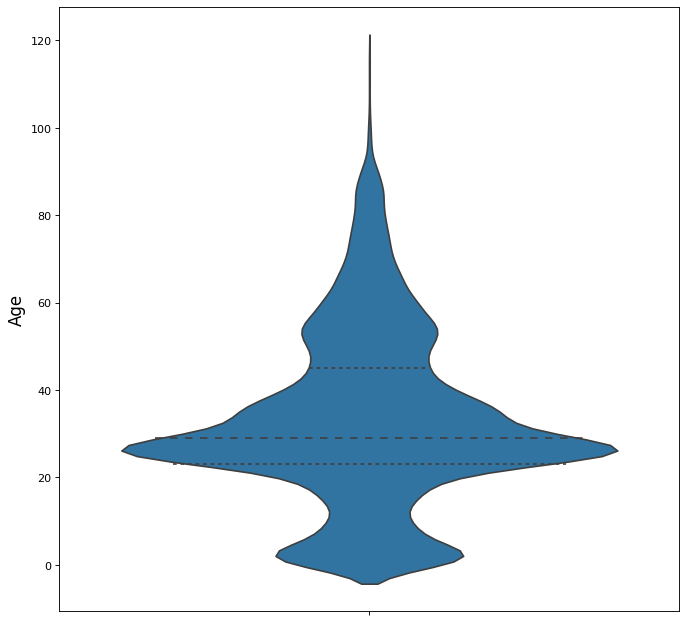

In [ ]:
violin_plot(y='age', data=dataset[['age']])



As we saw earlier, the majority of the data is in the 20-40 group

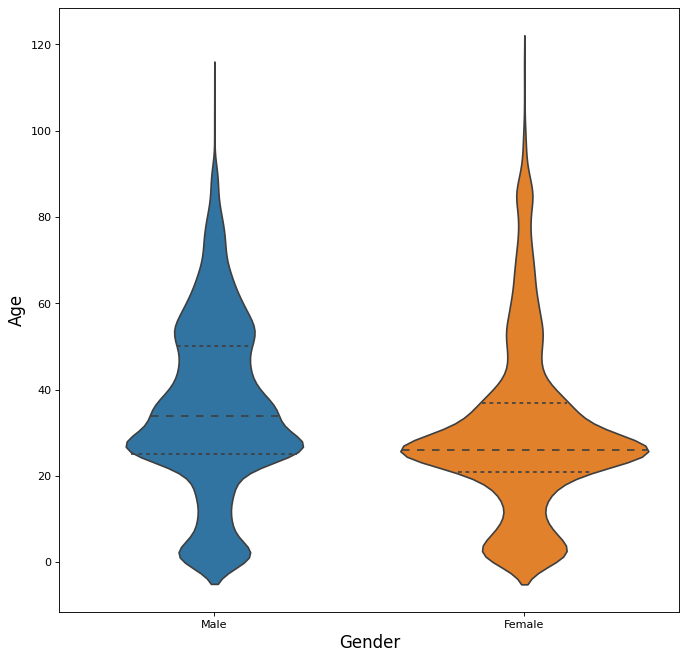

In [ ]:
violin_plot(y='age', x='gender', data=dataset[['age', 'gender']], x_name='Gender', xticklabels=[gender_mapping[0], gender_mapping[1]])

We can see that both genders are distributed equally in relation to each other (meaning more data in the young ages)

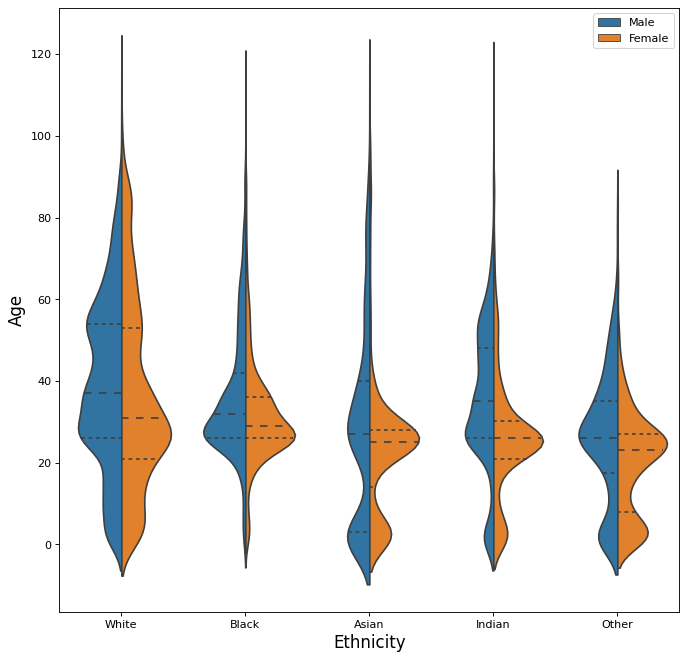

In [ ]:
violin_plot(y='age', x='ethnicity', data = dataset[['age', 'gender', 'ethnicity']], x_name='Ethnicity', xticklabels=[ethnicity_mapping[i] for i in range(5)], legend=True, hue='gender')


In this plot we are able to see that in the white group the ages are distributed more equally in comparison to the other groups. In the Black group for instance, the data distributed very poorly in relation to age.

##### **More Observations**

Here is another way to see the distribution of the data:

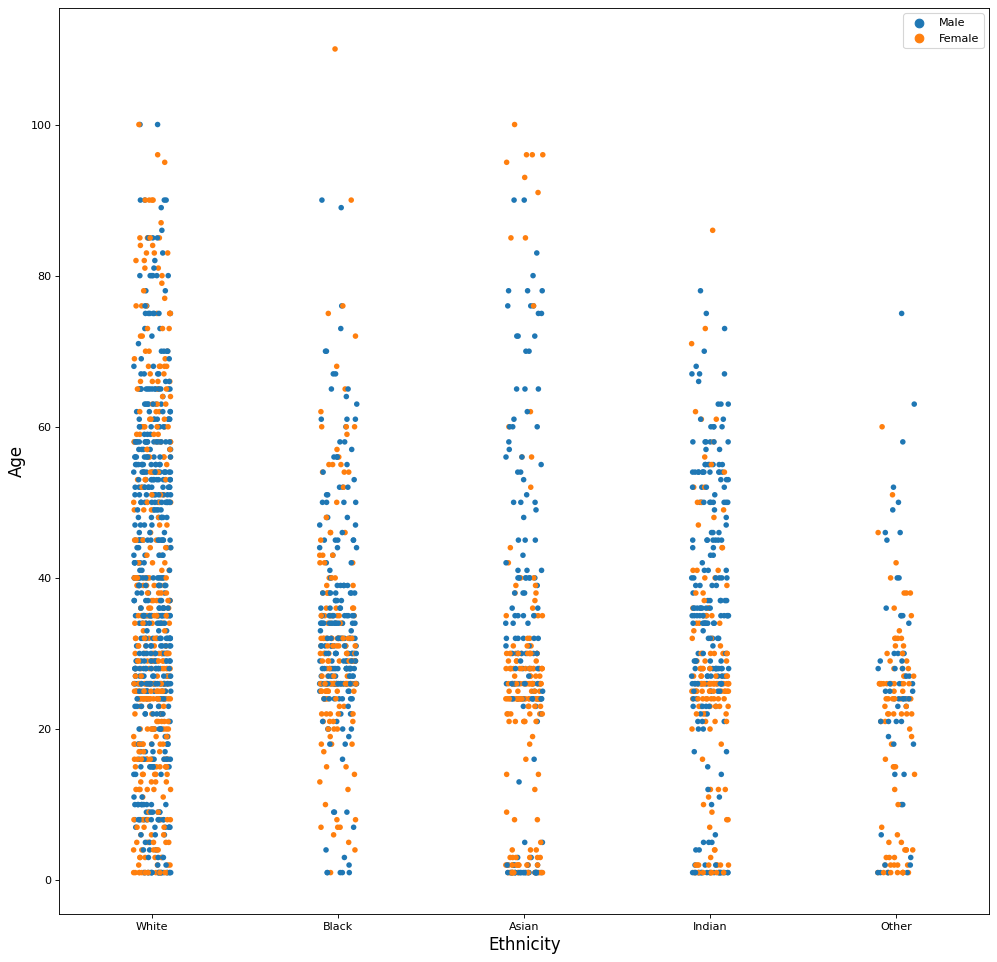

In [ ]:
plt.figure(figsize=(15, 15), dpi=80)
random_sample = dataset.sample(frac=0.1)
ax = sns.stripplot(y = 'age', x='ethnicity', data=random_sample[['age', 'gender', 'ethnicity']], hue='gender') 
ax.set_xticklabels([ethnicity_mapping[i] for i in range(5)])
ax.set_xlabel('Ethnicity', fontsize=15)
ax.set_ylabel('Age', fontsize=15)
ax.legend(handles=ax.legend_.legendHandles, labels=[gender_mapping[i] for i in range(2)])

Here we took a **random samples** from the data (we took only 0.1 of the data) and as before it seems like the data in the White group is distributed a lot more equally than in the other groups, where there the data in young ages is poorly distributed, and in the old ages it's hardly even exist.


For a final observation, we'll take a look at the folowing Factor-Plot:

<Figure size 1200x1200 with 0 Axes>

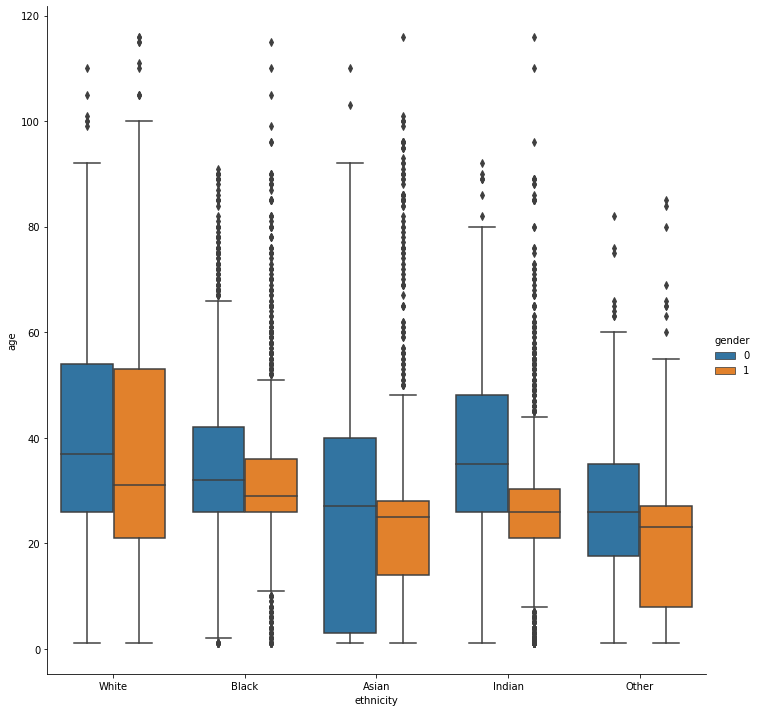

In [ ]:
plt.figure(figsize=(15, 15), dpi=80)
ax = sns.catplot(y = 'age', x='ethnicity', data=dataset[['age', 'gender', 'ethnicity']], hue='gender', kind='box', height=10) 
ax.set_xticklabels([ethnicity_mapping[i] for i in range(5)])


Here we can learn couple of things:

1.   The majority of the data is in the young ages, especially if we look at the Asian group where 3/4 of the males are below 50 and 1/4 of them are basically 0-5.
2.   In all of the groups, Females are younger than Males. It stands out even more in the Indian and the Other groups.  
3.   in all of the groups except the White group, the data of Males is spread larger than the data of Females, and therefore we tend to see a lot more outlayers in Females than in Males





### **Unsupervised Attempts**

#### **Transforming pixels into seperate columns**

In this section we took every pixle and transformed it into a column, so now we have 48x48 columns that can be used each one as a single feature.  
This action cost a lot of running time, so we executed it once and saved the dataset in drive, that way we can use it in the future.

In [ ]:
# transforming each pixle to a column,
# *** this action takes about one hour to execute! ***

array = np.zeros((len(dataset)))

for i in range(48):
  for j in range(48):
     name = '{}x{}'.format(i+1, j+1)
     dataset[name] = array

for index, row in dataset.iterrows():
  for i in range(48):
    for j in range(48):
      name = '{}x{}'.format(i+1, j+1)
      dataset[name][index] = row['pixels'][i][j]


In [ ]:
# load the file from my drive 
path = "/content/drive/My Drive/new.csv"   # path to the new dataset in my google-drive
dataset = pd.read_csv(path)

In [ ]:
dataset_shuffled = dataset.sample(frac=1).reset_index(drop=True)  # shuffle the dataset before we splitting it

In [ ]:
train, test = train_test_split(dataset_shuffled, test_size=0.2)

In [ ]:
features = dataset.loc[:, '1x1':'48x48']
features

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,1x29,1x30,1x31,1x32,1x33,1x34,1x35,1x36,1x37,1x38,1x39,1x40,...,48x9,48x10,48x11,48x12,48x13,48x14,48x15,48x16,48x17,48x18,48x19,48x20,48x21,48x22,48x23,48x24,48x25,48x26,48x27,48x28,48x29,48x30,48x31,48x32,48x33,48x34,48x35,48x36,48x37,48x38,48x39,48x40,48x41,48x42,48x43,48x44,48x45,48x46,48x47,48x48
0,129.0,128.0,128.0,126.0,127.0,130.0,133.0,135.0,139.0,142.0,145.0,149.0,147.0,145.0,146.0,147.0,148.0,149.0,149.0,150.0,153.0,153.0,153.0,152.0,153.0,153.0,153.0,153.0,153.0,151.0,149.0,147.0,146.0,146.0,144.0,143.0,140.0,134.0,129.0,129.0,...,135.0,130.0,125.0,122.0,118.0,115.0,114.0,116.0,121.0,123.0,124.0,123.0,124.0,122.0,124.0,125.0,128.0,129.0,131.0,132.0,135.0,135.0,135.0,136.0,138.0,135.0,133.0,124.0,90.0,104.0,123.0,129.0,134.0,138.0,142.0,144.0,144.0,146.0,146.0,146.0
1,164.0,74.0,111.0,168.0,169.0,171.0,175.0,182.0,184.0,188.0,193.0,199.0,200.0,199.0,200.0,196.0,198.0,192.0,193.0,188.0,187.0,186.0,187.0,188.0,183.0,182.0,178.0,177.0,175.0,174.0,176.0,174.0,172.0,165.0,158.0,153.0,147.0,142.0,138.0,131.0,...,219.0,212.0,193.0,195.0,193.0,194.0,176.0,153.0,167.0,203.0,197.0,161.0,141.0,165.0,177.0,171.0,153.0,120.0,91.0,75.0,71.0,68.0,60.0,63.0,103.0,155.0,164.0,167.0,145.0,173.0,168.0,189.0,223.0,241.0,236.0,232.0,204.0,182.0,170.0,148.0
2,67.0,70.0,71.0,70.0,69.0,67.0,70.0,79.0,90.0,103.0,116.0,132.0,145.0,155.0,161.0,166.0,169.0,175.0,177.0,178.0,179.0,180.0,183.0,186.0,187.0,188.0,192.0,194.0,198.0,203.0,206.0,213.0,214.0,216.0,220.0,219.0,215.0,213.0,211.0,211.0,...,80.0,77.0,75.0,71.0,68.0,64.0,65.0,66.0,69.0,76.0,80.0,84.0,87.0,92.0,96.0,100.0,105.0,109.0,116.0,129.0,142.0,158.0,177.0,197.0,211.0,211.0,202.0,168.0,128.0,116.0,117.0,113.0,116.0,116.0,117.0,117.0,115.0,112.0,111.0,108.0
3,193.0,197.0,198.0,200.0,199.0,200.0,202.0,203.0,204.0,205.0,208.0,211.0,211.0,211.0,209.0,205.0,204.0,204.0,204.0,205.0,205.0,207.0,207.0,207.0,207.0,208.0,208.0,208.0,208.0,207.0,207.0,205.0,204.0,203.0,202.0,202.0,202.0,205.0,209.0,214.0,...,191.0,184.0,175.0,165.0,156.0,149.0,148.0,147.0,147.0,148.0,151.0,150.0,150.0,151.0,153.0,154.0,158.0,162.0,168.0,171.0,179.0,183.0,190.0,200.0,205.0,211.0,215.0,217.0,217.0,216.0,218.0,222.0,227.0,228.0,228.0,230.0,231.0,235.0,239.0,246.0
4,202.0,205.0,209.0,210.0,209.0,209.0,210.0,211.0,212.0,214.0,218.0,219.0,220.0,221.0,221.0,220.0,221.0,221.0,221.0,220.0,220.0,222.0,222.0,222.0,220.0,220.0,218.0,218.0,218.0,217.0,217.0,218.0,218.0,219.0,219.0,218.0,220.0,222.0,219.0,223.0,...,173.0,163.0,150.0,153.0,158.0,162.0,166.0,170.0,176.0,185.0,191.0,193.0,196.0,197.0,197.0,197.0,195.0,195.0,195.0,192.0,189.0,183.0,177.0,174.0,171.0,169.0,168.0,169.0,168.0,165.0,165.0,167.0,167.0,167.0,168.0,171.0,171.0,167.0,163.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,127.0,100.0,94.0,81.0,77.0,77.0,74.0,99.0,102.0,98.0,128.0,145.0,160.0,177.0,187.0,180.0,189.0,198.0,181.0,179.0,181.0,191.0,198.0,204.0,204.0,207.0,199.0,203.0,208.0,202.0,202.0,195.0,176.0,173.0,159.0,149.0,137.0,108.0,91.0,100.0,...,12.0,6.0,7.0,35.0,94.0,92.0,101.0,95.0,97.0,120.0,95.0,117.0,126.0,142.0,130.0,122.0,116.0,130.0,125.0,137.0,131.0,99.0,25.0,21.0,21.0,9.0,6.0,10.0,12.0,13.0,17.0,17.0,20.0,19.0,19.0,59.0,92.0,95.0,94.0,105.0
23701,23.0,28.0,32.0,35.0,42.0,47.0,68.0,85.0,98.0,103.0,113.0,117.0,130.0,129.0,128.0,139.0,146.0,143.0,148.0,153.0,158.0,152.0,154.0,158.0,157.0,155.0,148.0,147.0,152.0,157.0,157.0,153.0,152.0,150.0,153.0,152.0,155.0,160.0,161.0,162.0,...,58.0,60.0,80.0,84.0,101.0,111.0,100.0,50.0,39.0,53.0,107.0,125.0,111.0,104.0,103.0,99.0,106.0,109.0,102.0,93.0,94.0,90.0,73.0,79.0,88.0,97.0,95.0,9

#### **Attempt to visualize features by lowering the dimensions to 2**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We'll try to see how the data is distributed by lowering the dimensions to only 2.  
It may seems useless but maybe we'll find something usefull.

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
features_pca


array([[  340.75947963,     8.11196943],
       [ 1719.76764718,  -314.47186667],
       [ 1479.80818381,  1121.53317068],
       ...,
       [ -238.07690081,  -821.64326341],
       [ -748.0083237 , -1739.55086126],
       [ 1509.48664943,  -187.92205171]])

The values don't say much, let's plot them as dots in 2d grid and see if they're saying anything to us.

First we will take look at the 'age' class:

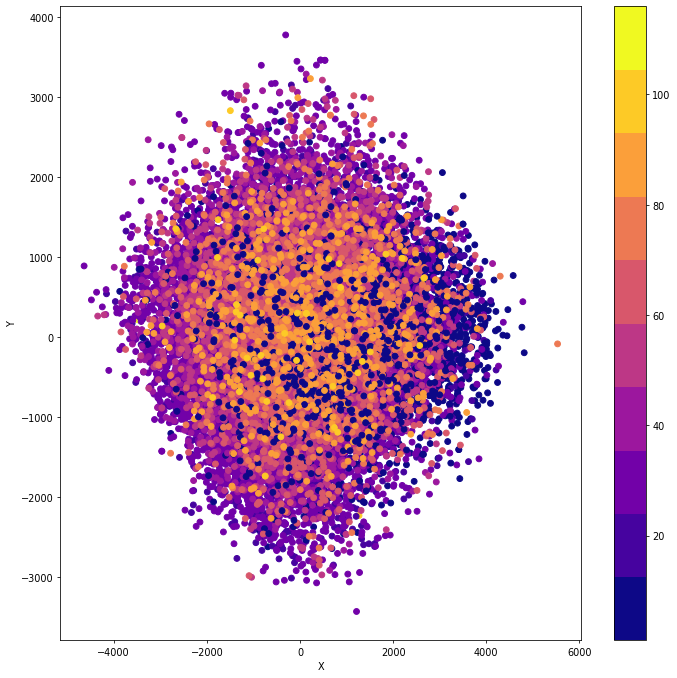

In [ ]:
plt.figure(figsize=(12, 12), dpi=70)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dataset['age'], cmap=plt.cm.get_cmap('plasma', 10))
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar();

Unfortunately, the transforming doesn't say much to us. we can see that maybe the older ages are more center than others, but the data in this ages is limited so we can't really count on that.

We'll check now with the **gender** values:

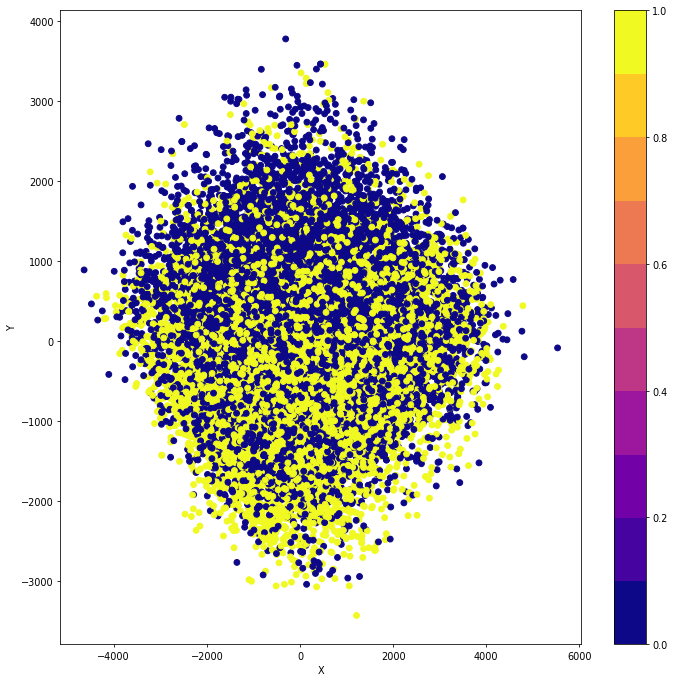

In [ ]:
plt.figure(figsize=(12, 12), dpi=70)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dataset['gender'], cmap=plt.cm.get_cmap('plasma', 10))
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar();

Again we can see that the males are more in the large values while the females more to the lower values (against the Y axis). Yet, this isn't as certain as we hoped.

At last, we'll look at the **'ethnicity'** lable to see if there's any success:

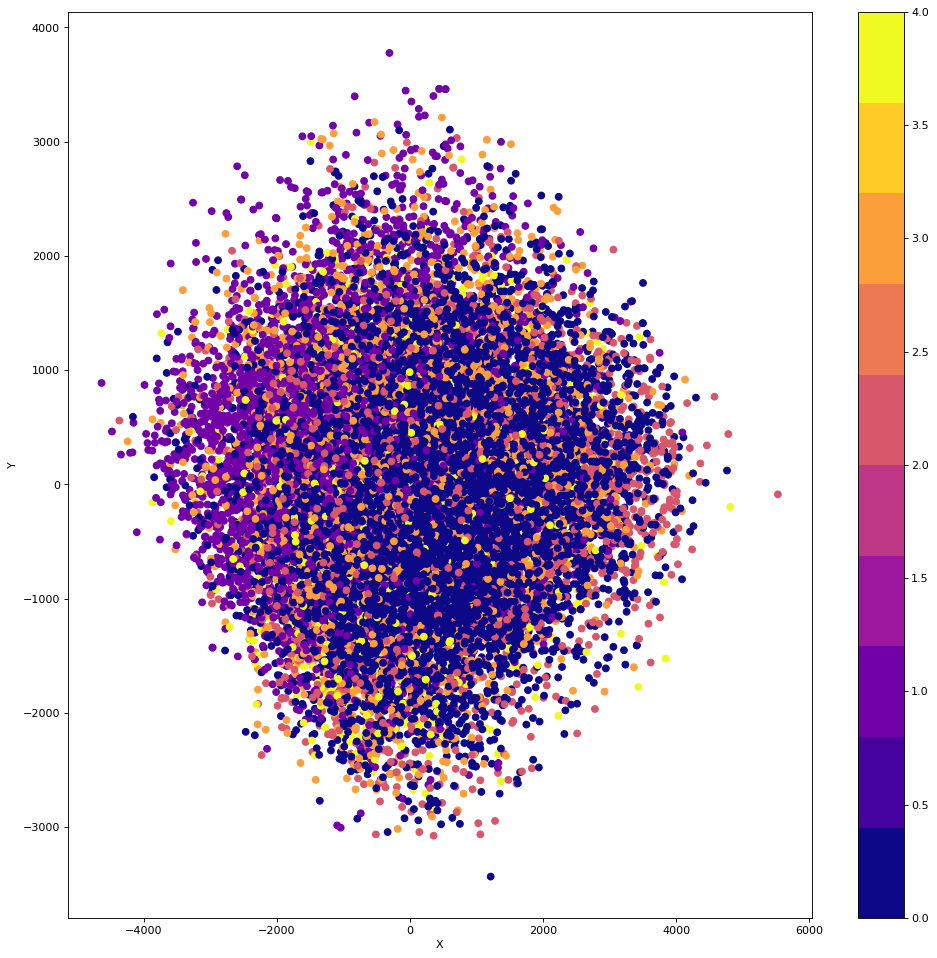

In [ ]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dataset['ethnicity'], cmap=plt.cm.get_cmap('plasma', 10))
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar();

In this case, we can see that the data is distributed almost equally, and the PCA didn't really worked in this case 

#### **Attempt to predict labels with GMM (clustering)**

In this section we'll try to see if GMM algorithm can label the data, while fitting it using our features.  
We will not use ALL the features, because it may take forever to fit 2304 columns. Intstead we'll lower the dimensions to 300 and we'll fit the algorithm on the newly-transformed features.

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
pca = PCA(n_components=300)
features_pca = pca.fit_transform(features)

We'll use two components for now, and see if it can somhow predict the binary division of our data - our gender column

In [ ]:
 gmm = GaussianMixture(n_components=2).fit(features_pca)
 labels = gmm.predict(features_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



In [ ]:
dataset2 = dataset

In [ ]:
dataset2['new_labels'] = labels


In [ ]:
male = len(dataset2[(dataset2['new_labels'] == 0) & (dataset2['gender'] == 0)])
print(male/len(dataset2[dataset2['new_labels'] == 0]))

0.4492858000240067


In [ ]:
male = len(dataset2[(dataset2['new_labels'] == 1) & (dataset2['gender'] == 0)])
print(male/len(dataset2[dataset2['new_labels'] == 1]))

0.562508130610121


Unfortunately we can see from the distribution of both genders in relation to the new labels, that the algorithm didn't do so well regarding the gender classification.

We can do the same with the other classes but the results would be the same:

In [ ]:
gmm = GaussianMixture(n_components=5).fit(features_pca)
labels = gmm.predict(features_pca)

In [ ]:
dataset2['new_labels'] = labels

In [ ]:
for j in range(5):
  print(f'Ethnicity {j}:')
  for i in range(5):
    ethnicity = len(dataset2[(dataset2['new_labels'] == i) & (dataset2['ethnicity'] == j)])
    print(ethnicity/len(dataset2[dataset2['new_labels'] == i ]))
  print('\n')

Ethnicity 0:
0.39374482187241094
0.41205211726384366
0.391358955036423
0.4807600191601469
0.4223075368761366


Ethnicity 1:
0.21706710853355426
0.24484256243213898
0.1615172067319769
0.1267763052850072
0.230147504546373


Ethnicity 2:
0.1443661971830986
0.10477741585233442
0.2167797035920623
0.1361967108414498
0.12830874924227118


Ethnicity 3:
0.17771333885666943
0.1775244299674267
0.146948003014318
0.17946670924477087
0.15235401091129522


Ethnicity 4:
0.06710853355426678
0.06080347448425624
0.08339613162521979
0.07680025546862526
0.06688219842392402




As we can see, none of the ethnicities got a match of above 50% to one of the new labels. that means that the GNN model couldn't scatter the features in a meaningfull order for us.

*If we'll had enough time later, we could just pick the right and meaningful pixels out of the data, and repeat the process again.*

### **Visual information analysis using sklearn clustring**

First, we present a small sample of images before we run the FeatureAgglomeration on this sample

In [ ]:
from sklearn import cluster
import matplotlib.cm as cm

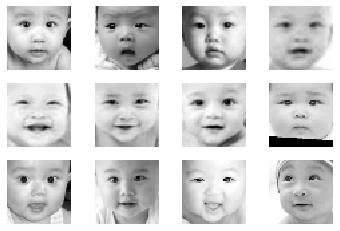

In [ ]:
pixels = dataset.pixels
pixels_list = pixels.to_list()
images = np.array(pixels_list)

for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(images[i], cmap= plt.cm.gray, interpolation='nearest')
  path = '/content/image{0}.png'.format(i)
  plt.imsave(path, images[i])
  plt.axis('off')

plt.show()



Now, we represent an image structure (grid) using a connectivity graph that indicates for each pixel who its neighbors are.

In [ ]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(*images[0].shape)

Now, the connectivity graph can be used to define a feature space for the image - one that represents the euclidean distance between the values of each pixel and the values of its neighbors. 
Thus, an image can be represented by the euclidean distances between the pixels.

In this example, a connectivity graph will be constructed on the images and we will be clustering their features, as defined above, using an agglomeration feature for 32 groups, as follows:

In [ ]:
X = np.reshape(images, (len(images), -1))
agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32, affinity='euclidean')
agglo.fit(X)

FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
                     connectivity=<2304x2304 sparse matrix of type '<class 'numpy.int64'>'
	with 11328 stored elements in COOrdinate format>,
                     distance_threshold=None, linkage='ward', memory=None,
                     n_clusters=32,
                     pooling_func=<function mean at 0x7fadb96287a0>)

Now, we have images represented by a set of properties. 
We can recover the images from them that way:

In [ ]:
X_reduced = agglo.transform(X)
X_restored = agglo.inverse_transform(X_reduced)

We present the recovered images:

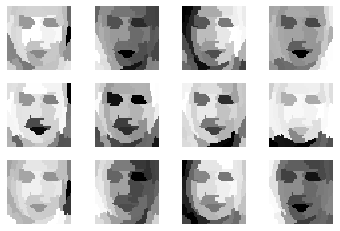

In [ ]:
images_restored = np.reshape(X_restored, images.shape)

for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(images_restored[i], cmap= plt.cm.gray, interpolation='nearest')
  plt.axis('off')

plt.show()


Indeed, it seems that the set of characteristics that reasonably reproduced the faces.


We examine the labels given to each pixel. This is how we see where the information is.

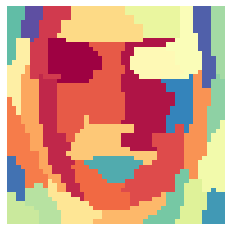

In [ ]:
plt.imshow(np.reshape(agglo.labels_, images[0].shape), interpolation='nearest', cmap=cm.get_cmap("Spectral"))
plt.axis('off')
plt.show()


Here we can see that through sklearn we identified the significant features that represent a face. We can use them if we want to re-reduce a dimension or focus only on significant features in order to improve the accuracy of our model we can do this by taking these pixels only and considering them only.

### Last attempt - CNN

In the previous attemts, we looked at every single one of our features (i.e. our 2D array of pixels) and we tried to extract meaningful data that will direct us into the the desired classification model. The problem in these approches was in the premise that all the pixles have the same value or importance in determining which is the right classification for the global image.  

Like we saw,this assumption is wrong and ends in failure and the reason is pretty simple: not all the pixels have the same influence, and more important - the exact location, the ID of the pixel itself isn't really the feature, but a set of pixels or more precisely - a set of pixels that represents a feature in a smaller dimension than the existing dimension that we have.   

This understanding leads us to the next approach - CNN (Convolutional Neural Network).  

The benefits in this approach is that the neural network will first try to extract new features out of our existing features - our 2D arrays of pixels. In our CNN, the network will not take each pixle into account individually but will look at all the pixels globally. That way, we can extract meaninful features instead a lot of small and single features that don’t really say much each one on its own.

In [ ]:
## normalize pixels 
dataset['pixels'] = dataset['pixels'].apply(lambda x: x/255)

In [ ]:
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Our main model will be simple and uncomplicated, as our experience in assembling neural networks is not great but we hope it will suffice and meet our expectations. The network built will consist of two convolutional layers with max-pulling and normalization layers to each one of them. Finally we'll add a Flat layer that will try to classify the features.
We'll show the training loss and the validation loss, as well as other aspects of the training process.  

After that, we will try to evaluate our results and see if we can get better results from a pretrained model that maybe more complex than ours. 

In [ ]:
class myCNNModel:
  def __init__(self, X, class_name, activation, loss,y):
    self.X = X
    self.generate_data(self.X)
    self.y = y
    if self.y is None:
      self.y = np_utils.to_categorical(dataset[class_name])
    else:
      self.y= np_utils.to_categorical(self.y)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=37)

    self.model = keras.Sequential([
    L.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2)),
    L.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=(2, 2)),
    L.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"),
    L.MaxPool2D(pool_size=(2, 2)),
    L.Flatten(),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
    L.Dense(len((self.y)[0]), activation= activation)
    ])

    self.model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    
    early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)
        
    self.callback = [early_stopping, learning_rate_reduction]

    print(model.summary())


  def generate_data(self, X):
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images horisontally
        vertical_flip=False)  # randomly flip images vertically

    datagen.fit(X)

  
  def fit_my_model(self, epochs, batch_size):
    self.history = self.model.fit(
      self.X_train,
      self.y_train,
      epochs=epochs,
      batch_size=batch_size,
      callbacks=[self.callback],
      validation_data=(self.X_test, self.y_test)
    )

  
  def show_results(self):
    fig = px.line(title='Training History')
    fig.add_scatter(y=self.history.history['loss'], name='Training loss',)
    fig.add_scatter(y=self.history.history['val_loss'],mode='lines', name='Validation loss')
    fig.show()




In [ ]:
X = np.array(dataset['pixels'].tolist())

## Converting pixels from 2D to 3D
X = X.reshape(X.shape[0],48,48,1)

In [ ]:
gender_model = myCNNModel(X, 'gender','sigmoid', 'binary_crossentropy',y=None)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
gender_model.fit_my_model(epochs=200, batch_size=64)

Epoch 1/200
255/255 [==============================] - 6s 20ms/step - loss: 0.5093 - accuracy: 0.7713 - val_loss: 0.6342 - val_accuracy: 0.5538
Epoch 2/200
255/255 [==============================] - 5s 19ms/step - loss: 0.3105 - accuracy: 0.8648 - val_loss: 0.3155 - val_accuracy: 0.8555
Epoch 3/200
255/255 [==============================] - 5s 18ms/step - loss: 0.2576 - accuracy: 0.8900 - val_loss: 0.2804 - val_accuracy: 0.8756
Epoch 4/200
255/255 [==============================] - 5s 19ms/step - loss: 0.2325 - accuracy: 0.9034 - val_loss: 0.2890 - val_accuracy: 0.8656
Epoch 5/200
255/255 [==============================] - 5s 19ms/step - loss: 0.2065 - accuracy: 0.9148 - val_loss: 0.2928 - val_accuracy: 0.8645
Epoch 6/200
255/255 [==============================] - 5s 19ms/step - loss: 0.1869 - accuracy: 0.9235 - val_loss: 0.2960 - val_accuracy: 0.8729

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/200
255/255 [==============================] - 

In [ ]:
gender_model.show_results()

In [ ]:
categorical_age = pd.cut(dataset["age"], bins=5 ,labels=range(5))
age_model = myCNNModel(X=X, class_name="age", activation='softmax', loss='categorical_crossentropy', y=categorical_age)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
age_model.fit_my_model(epochs=200, batch_size=64)

Epoch 1/200
255/255 [==============================] - 6s 20ms/step - loss: 1.0529 - accuracy: 0.5886 - val_loss: 1.2879 - val_accuracy: 0.3237
Epoch 2/200
255/255 [==============================] - 5s 19ms/step - loss: 0.7755 - accuracy: 0.6718 - val_loss: 0.9954 - val_accuracy: 0.6127
Epoch 3/200
255/255 [==============================] - 5s 19ms/step - loss: 0.7037 - accuracy: 0.6942 - val_loss: 0.8054 - val_accuracy: 0.6406
Epoch 4/200
255/255 [==============================] - 5s 19ms/step - loss: 0.6553 - accuracy: 0.7181 - val_loss: 0.7420 - val_accuracy: 0.6656
Epoch 5/200
255/255 [==============================] - 5s 18ms/step - loss: 0.6142 - accuracy: 0.7377 - val_loss: 0.6819 - val_accuracy: 0.6989
Epoch 6/200
255/255 [==============================] - 5s 19ms/step - loss: 0.5746 - accuracy: 0.7483 - val_loss: 0.6684 - val_accuracy: 0.7109
Epoch 7/200
255/255 [==============================] - 5s 19ms/step - loss: 0.5509 - accuracy: 0.7610 - val_loss: 0.8327 - val_accuracy:

In [ ]:
age_model.show_results()

In [ ]:
ethnicity_model = myCNNModel(X=X, class_name="ethnicity", activation='softmax', loss='categorical_crossentropy', y=None)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
ethnicity_model.fit_my_model(epochs=200, batch_size=64)

Epoch 1/200
255/255 [==============================] - 6s 20ms/step - loss: 1.2040 - accuracy: 0.5626 - val_loss: 1.4113 - val_accuracy: 0.4436
Epoch 2/200
255/255 [==============================] - 5s 19ms/step - loss: 0.8629 - accuracy: 0.6965 - val_loss: 0.9272 - val_accuracy: 0.6375
Epoch 3/200
255/255 [==============================] - 5s 19ms/step - loss: 0.7590 - accuracy: 0.7368 - val_loss: 0.7447 - val_accuracy: 0.7501
Epoch 4/200
255/255 [==============================] - 5s 18ms/step - loss: 0.6850 - accuracy: 0.7619 - val_loss: 0.7758 - val_accuracy: 0.7314
Epoch 5/200
255/255 [==============================] - 5s 19ms/step - loss: 0.6318 - accuracy: 0.7817 - val_loss: 0.7610 - val_accuracy: 0.7513
Epoch 6/200
255/255 [==============================] - 5s 19ms/step - loss: 0.5868 - accuracy: 0.7962 - val_loss: 0.7136 - val_accuracy: 0.7517
Epoch 7/200
255/255 [==============================] - 5s 19ms/step - loss: 0.5411 - accuracy: 0.8105 - val_loss: 0.7208 - val_accuracy:

In [ ]:
ethnicity_model.show_results()

**Image Regression: Prediction Using Pretrained ResNet50 Model**

In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 64 kB/s 
     |████████████████████████████████| 6.8 MB 36.1 MB/s 
     |████████████████████████████████| 981 kB 39.1 MB/s 
     |████████████████████████████████| 263 kB 45.0 MB/s 
     |████████████████████████████████| 2.8 MB 37.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 468 kB 45.6 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.2-py3-none-any.whl size=25290606 sha256=71db544c3b7df992320f7a60c0341f90028b4dc39c94b1121ff7440517a5ba17
  Stored in directory: /root/.cache/pip/wheels/df/2b/04/7c821b51e637ec480060989b5030d0c4cce16efe0d67bff94b
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=3a092aa375945485f

In [ ]:
%matplotlib inline 
import os
import ktrain
from ktrain import vision as vis 
import re

**Download the Dataset**

we use the UTK Face Dataset. Download the data from http://aicip.eecs.utk.edu/wiki/UTKFace and extrct each of the three zip files to the same folder.

In [ ]:
!git clone https://github.com/laxmimerit/Image-Dataset-for-Age-Prediction.git

Cloning into 'Image-Dataset-for-Age-Prediction'...
remote: Enumerating objects: 47107, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 47107 (delta 0), reused 2 (delta 0), pack-reused 47104
Receiving objects: 100% (47107/47107), 1.37 GiB | 32.38 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (24110/24110), done.


**STEP 1: Load and Preprocess the Dataset**

The target age, gender and ethnicity attributes in this dataset are encoded in the filename. More specifically, filenames are of the form:

              [age]_[gender]_[race]_[date&time].jpg

We are interested in extracting the age, gender and ethnicity for use as a numerical target. Let us first construct a regular expression to extract each attribute from the filename. Then, we can supply the pattern to images_from_fname to load and preprocess the dataset. Supplying is_regression=True is important here, as it tells ktrain that the integer targets representing attributes should be treated as a numerical target, as oppposed to a class label.

Set DATADIR to the folder where you extracted all the images.

**Train Test Split**

In [ ]:
DATADIR = '/content/Image-Dataset-for-Age-Prediction/images'

def split_data(pattern):
    data_aug = vis.get_data_aug(horizontal_flip=True)
    (train_data, val_data, preproc) = vis.images_from_fname(DATADIR, 
                                                         pattern= pattern,
                                                         data_aug = data_aug,
                                                         is_regression = True,
                                                         random_state = 42)
    return (train_data, val_data, preproc)

In [ ]:
pattern_age = r'([^/]+)_\d+_\d+_\d+.jpg$'
(train_data_age, val_data_age, preproc_age) = split_data(pattern_age)

pattern_gender = r'\d+_([^/]+)_\d+_\d+.jpg$'
(train_data_gender, val_data_gender, preproc_gender) = split_data(pattern_gender)

pattern_ethnicity = r'\d+_\d+_([^/]+)_\d+.jpg$'
(train_data_ethnicity, val_data_ethnicity, preproc_ethnicity) = split_data(pattern_ethnicity)

/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/39_1_20170116174525125.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/61_3_20170109150557335.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/24_0_1_20170116220224657 .jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-fo

['label']
       label
12304   54.0
6161    85.0
19807   19.0
21202   33.0
14941   14.0
['label']
       label
16139   36.0
14926    6.0
8979    31.0
12077   55.0
14568   62.0
Found 24107 images belonging to 1 classes.
Found 21690 validated image filenames.
Found 2411 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/39_1_20170116174525125.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/61_3_20170109150557335.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/24_0_1_20170116220224657 .jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-fo

['label']
       label
12304    0.0
6161     0.0
19807    0.0
21202    1.0
14941    0.0
['label']
       label
16139    0.0
14926    1.0
8979     1.0
12077    0.0
14568    1.0
Found 24107 images belonging to 1 classes.
Found 21690 validated image filenames.
Found 2411 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/39_1_20170116174525125.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/61_3_20170109150557335.jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-for-Age-Prediction/images/24_0_1_20170116220224657 .jpg -  skipping this file
  warnings.warn('Could not extract target for %s -  skipping this file'% (fname))
/usr/local/lib/python3.7/dist-packages/ktrain/vision/data.py:736: UserWarning: Could not extract target for /content/Image-Dataset-fo

['label']
       label
12304    1.0
6161     0.0
19807    4.0
21202    3.0
14941    0.0
['label']
       label
16139    1.0
14926    4.0
8979     1.0
12077    1.0
14568    1.0
Found 24107 images belonging to 1 classes.
Found 21690 validated image filenames.
Found 2411 validated image filenames.


**Create a ResNet50 Model for Age, Gender and Ethnicity and Wrap in Learner**

We use the image_regression_model function to create a ResNet50 model

In [ ]:
def build_resNet_model(train_data, val_data):
  model = vis.image_regression_model('pretrained_resnet50',
                                   train_data = train_data,
                                   val_data = val_data)
  return model


In [ ]:
age_model = build_resNet_model(train_data_age, val_data_age)
gender_model = build_resNet_model(train_data_gender, val_data_gender)
ethnicity_model = build_resNet_model(train_data_ethnicity, val_data_ethnicity)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
94781440/94765736 [==============================] - 1s 0us/step
pretrained_resnet50 model created.
The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
pretrained_resnet50 model created.
The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
pretrained_resnet50 model created.


In [ ]:
def build_learner(model, train_data, val_data):
  learner = ktrain.get_learner(model=model,
                             train_data = train_data,
                             val_data = val_data,
                             workers = 8,
                             use_multiprocessing=False,
                             batch_size = 64)
  return learner  

In [ ]:
age_learner = build_learner(age_model, train_data_age, val_data_age)
gender_learner = build_learner(gender_model, train_data_gender, val_data_gender)
ethnicity_learner = build_learner(ethnicity_model, train_data_ethnicity, val_data_ethnicity)

**Estimate Learning Rate**

We will select a learning rate associated with falling loss from the plot displayed.

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
338/338 [==============================] - 477s 1s/step - loss: 909.2144 - mae: 23.5731
Epoch 2/2
338/338 [==============================] - 187s 525ms/step - loss: 9473.3057 - mae: 41.3304


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


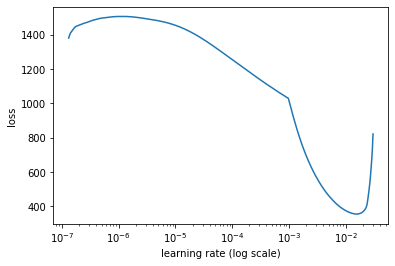

In [ ]:
age_learner.lr_find(max_epochs=2)
age_learner.lr_plot()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
338/338 [==============================] - 516s 1s/step - loss: 0.1504 - mae: 0.2985
Epoch 2/2
338/338 [==============================] - 63s 156ms/step - loss: 8.0137 - mae: 0.8358


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


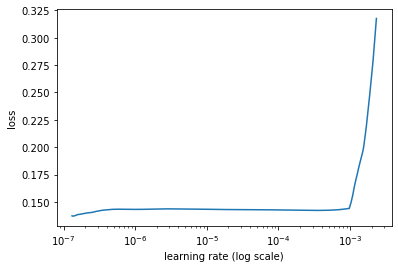

In [ ]:
gender_learner.lr_find(max_epochs=2)
gender_learner.lr_plot()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
338/338 [==============================] - 478s 1s/step - loss: 11.7738 - mae: 2.7211
Epoch 2/2
338/338 [==============================] - 53s 126ms/step - loss: 120.2780 - mae: 8.3711


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


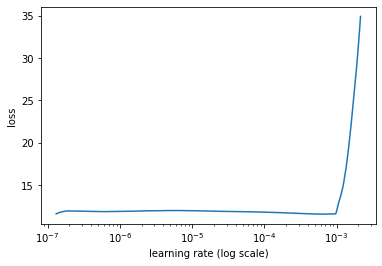

In [ ]:
ethnicity_learner.lr_find(max_epochs=2)
ethnicity_learner.lr_plot()


From the plot above, we choose a learning rate of 1e-4.

**Training the Models**

In [ ]:
def fit_model(learner, epochs):
  learner.fit_onecycle(lr= 1e-4,epochs= 4)
  learner.freeze(15) # unfreeze all but the first 15 layers
  learner.fit_onecycle(lr= 1e-4,epochs= epochs)

In [ ]:
fit_model(age_learner, epochs=3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
339/339 [==============================] - 533s 2s/step - loss: 443.7584 - mae: 15.8631 - val_loss: 221.2428 - val_mae: 11.4043
Epoch 2/4
339/339 [==============================] - 531s 2s/step - loss: 218.7606 - mae: 11.2597 - val_loss: 172.3792 - val_mae: 10.2115
Epoch 3/4
339/339 [==============================] - 526s 2s/step - loss: 192.0515 - mae: 10.5828 - val_loss: 157.5315 - val_mae: 9.9138
Epoch 4/4
339/339 [==============================] - 529s 2s/step - loss: 183.3961 - mae: 10.3577 - val_loss: 151.1030 - val_mae: 9.6138


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
339/339 [==============================] - 580s 2s/step - loss: 132.5267 - mae: 8.6030 - val_loss: 193.8993 - val_mae: 10.3519
Epoch 2/3
339/339 [==============================] - 573s 2s/step - loss: 98.9740 - mae: 7.3672 - val_loss: 88.9336 - val_mae: 6.7617
Epoch 3/3
339/339 [==============================] 

In [ ]:
age_learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
fit_model(gender_learner, epochs=5)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
339/339 [==============================] - 554s 2s/step - loss: 8.7559 - mae: 2.3289 - val_loss: 3.1273 - val_mae: 1.4076
Epoch 2/4
339/339 [==============================] - 522s 2s/step - loss: 6.7156 - mae: 2.0465 - val_loss: 2.1121 - val_mae: 1.1271
Epoch 3/4
339/339 [==============================] - 526s 2s/step - loss: 5.1718 - mae: 1.7906 - val_loss: 1.3019 - val_mae: 0.8858
Epoch 4/4
339/339 [==============================] - 523s 2s/step - loss: 4.0659 - mae: 1.5883 - val_loss: 1.0920 - val_mae: 0.8110


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
339/339 [==============================] - 575s 2s/step - loss: 3.5323 - mae: 1.4225 - val_loss: 3.3874 - val_mae: 0.9404
Epoch 2/5
339/339 [==============================] - 569s 2s/step - loss: 0.9391 - mae: 0.6730 - val_loss: 0.7331 - val_mae: 0.5124
Epoch 3/5
339/339 [==============================] - 568s 2s/step - loss: 0.3164

In [ ]:
gender_learner.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
fit_model(ethnicity_learner, epochs=5)

NameError: ignored

In [ ]:
ethnicity_learner.model.summary()

**Make Predictions**

Let's make predictions on individual photos. We select randomly from the entire image directory

In [ ]:
import glob, random, os
from keras.preprocessing import image

In [ ]:
file_path_type = ["/content/Image-Dataset-for-Age-Prediction/images/*.jpg"]
images = glob.glob(random.choice(file_path_type))
PATTERN = r'([^/]+)_([^/]+)_([^/]+)_\d+.jpg$'
p = re.compile(PATTERN)

In [ ]:
age_predictor = ktrain.get_predictor(age_learner.model, preproc_age)
gender_predictor = ktrain.get_predictor(gender_learner.model, preproc_gender)
ethnicity_predictor = ktrain.get_predictor(ethnicity_learner.model, preproc_ethnicity)

In [ ]:
def get_random_image():
  random_image = random.choice(images)
  filename = os.path.basename(random_image)
  return filename

def show_prediction(fname):
  fname = DATADIR + '/' + fname
  age_pred = round(age_predictor.predict_filename(fname)[0])
  gender_pred = round(gender_predictor.predict_filename(fname)[0])
  ethnicity_pred = round(ethnicity_predictor.predict_filename(fname)[0])

  age_actual = int(p.search(fname).group(1))
  gender_actual = int(p.search(fname).group(2))
  ethnicity_actual = int(p.search(fname).group(3))

  
  vis.show_image(fname)
  print("Predicted Age: %s | Actual Age: %s" % (age_pred, age_actual))
  print("Predicted Gender: %s | Actual Gender: %s" % ('Female' if gender_pred == 1 else 'male', 'Female' if gender_actual == 1 else 'male'))
  print("Predicted Ethnicity: %s | Actual Ethnicity: %s" % (ethnicity_pred, ethnicity_actual))

In [ ]:
random_img = get_random_image()
show_prediction(random_img) 

In [ ]:
random_img = get_random_image()
show_prediction(random_img) 

## **Conclusions**

**Results**

**CNN:**

1.   **Age accuracy:** 0.7330 ,  **Epochs:** 16,  **Train time:** 1.35m
2.   **Gender accuracy:** 0.8959,  **Epochs:** 13,  **Train time:** 1.1m
3.   **Ethnicity accuracy:** 0.7854,  **Epochs:** 20,  **Train time:** 1.6m

**ResNet50:**

1.   **Age accuracy:** 6.1056,  **Epochs:** 7,  **Train time:** 1:01h
2.   **Gender accuracy:** 0.2409,  **Epochs:** 9,  **Train time:**1:22h
3.   **Ethnicity accuracy:** 0.7414,  **Epochs:** 9,  **Train time:** 1:20h

*   **CNN**

     As we can see, CNN models give us good accuracy in a very short time with clean pictures. Apparently if we were to run this model on original images it would take longer training time and with less good accuracy result.

*   **ResNet50** 
    
    The ResNet50 model is better than the CNN model because the ResNet50 models give high accuracy with a minimum of epochs and with original pictures but the big minus is that the training takes a lot of time significantly compared to CNN


### **Clean Data VS Original Pictures**

**OpenCV**

During the project we tried to use with all kinds of algorithms described in the book that OpenCV package provides but without success because most of the algorithms are not updated and are no longer supported in the new versions and also the online documentation does not provide so all attempts failed.

**PCA and Clustering with GNN On visual data**

Although we didn't succeed to find a reasonable model in this sectuion, and it maybe seems pointless to present it, our intention was to pull out the meaningfull pixels (using OpenCV) and repeat the process again. We were very curious about what the results would be in that case, but unfortunatelly we didn't succeed in that and if we would invest a little bit more time in this we believe that we would be able to maybe find some very interesting results.

### **Working with Google Colab**

The benefits of Google Colab are very promising and should facilitate collaboration, cloud storage, free graphics and packages already installed, but for us working with Google Colab made it difficult throughout the project because over time we could only work on an evening project, and write or edit codes in it. temporarily. Impossible and limited, so in most cases we had to recover unsaved code or coordinate between us who would work on the project and it wasted a lot of time.
Another thing, we occasionally experienced disconnections from the GPU due to usage restrictions, which caused us to stop working because training resnet50 models without the GPU took hours.

## **Self Reflection**

(David) personally I'm very interested in working with visual data and overall data science is one of my major interests. That's why I had a great time working on this project, and when I took the time to sit down and work on this, I usually found myself spending much more time than I planed to spend in the beginning.  

Working with Hana was actually the first time I worked with a partner on a project, and it was really great. I think we knew how to utilize all our resources wisely and divided the work between us in a way that suited both of our schedules. Working with Hana flowed and although parts of the project we did separately, it was important for both of us to understand one another and our partner's work.

(Hana)For me as a Full Stack developer it was an interesting and fascinating experience to get to know and touch the world of data science. My goal during this project was to try to reach an interesting conclusion, so I read and researched all kinds of algorithms for visual information analysis, and although it is impossible to feel the efforts and time invested because I have not yet reached an interesting conclusion for me it was worth every second because I gained a lot of experience and knowledge.                                                                 

Working with David was great and very helpful because David came with extensive knowledge in the data sciences and with a lot of motivation and desire on both of us to research and deepen the project and achieve good results. The division of work between us was correct and precise as well as the progress and timeliness.